# Connect to drive & import libraries

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import os
from keras.engine import Layer
from keras.layers import Lambda, Input, Dense, LSTM, RepeatVector
from keras.models import Model
import matplotlib.pyplot as plt
import keras
import numpy as np
import nltk
import tqdm
import tensorflow_hub as hub
import string
from keras import backend as K
import tensorflow as tf
import tensorflow.keras.backend as B
import tensorflow_hub as hub
from tensorflow.python.keras.engine import Layer

In [4]:
tf.__version__

'1.15.2'

In [5]:
hub.__version__

'0.8.0'

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Constants

In [0]:
# data parameters
dataset_address = 'drive/My Drive/CA5_Sabri_810198312/Datasets/spam.csv'
test_data_percentage = 0.2
# model parameters
learning_rate = 0.0002
batch_size = 32
max_sequence_length = 128
number_of_epochs = [1, 10, 20, 50]
# model links
bert_model_hub_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
elmo_model_hub_link = 'https://tfhub.dev/google/elmo/3'

# Reading & Pre-processing the data

In [10]:
df = pd.read_csv(dataset_address, sep=',', encoding = "ISO-8859-1")
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [0]:
all_Y = df.v1.values
all_X = df.v2.values

## Clean and tokenize 

In [0]:
def clean_text(all_X, tokenizer_mod=None):
  nltk_eng_stopwords = nltk.corpus.stopwords.words('english')
  converted_X = []
  for this_x in all_X:
    this_x_lower = this_x.lower()
    this_x_no_punc = this_x_lower.translate(str.maketrans('', '', string.punctuation))
    this_x_tokenized = nltk.tokenize.word_tokenize(this_x_no_punc)
    this_x_no_stopword = [val for val in this_x_tokenized if not val in nltk_eng_stopwords]
    converted_X.append(this_x_no_stopword)
  return converted_X

def convert_y_to_0_and_1(all_Y):
  label_number_mapping = {'ham': [1, 0], 'spam': [0, 1]}
  converted_y = [label_number_mapping[val] for val in all_Y]
  return converted_y

In [0]:
all_X_cleaned_for_elmo = clean_text(all_X)

In [0]:
all_y_converted = convert_y_to_0_and_1(all_Y)

### Testing Elmo results

In [15]:
print('X[0] => before: {} and after: {}'.format(all_X[0], all_X_cleaned_for_elmo[0]))
print('Y[0] => before: {} and after: {}'.format(all_Y[0], all_y_converted[0]))

X[0] => before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... and after: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
Y[0] => before: ham and after: [1, 0]


# Creating Model

In [16]:
this_optimizer = keras.optimizers.Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def plot_accuracy_and_loss(file_save_name, history):
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_accuracy.png')
  plt.cla()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.savefig(file_save_name+'_loss.png')
  plt.cla()

## Using Elmo

In [0]:
def create_req_elmo_inputs(all_X):
  X_input_tokens, X_input_seqlens = [], []

  for this_x in tqdm.tqdm(all_X, position=0, leave=True):
    this_x_possible_section = this_x[:max_sequence_length]
    X_input_tokens.append(" ".join(this_x_possible_section))
    X_input_seqlens.append(len(this_x_possible_section))

  return X_input_tokens, X_input_seqlens

In [0]:
all_X_preped_for_elmo = np.array([" ".join(val[:max_sequence_length]) for val in all_X_cleaned_for_elmo], dtype=object)

In [0]:
X_train_elmo, X_test_elmo, y_train_elmo, y_test_elmo = train_test_split(all_X_preped_for_elmo, all_y_converted, test_size=test_data_percentage, random_state=42)

In [21]:
X_train_elmo[0]

'im boat still moms check yo im half naked'

In [0]:
X_train_elmo = np.asarray(X_train_elmo, dtype="str")
X_test_elmo = np.asarray(X_test_elmo, dtype="str")
y_train_elmo = np.asarray(y_train_elmo, dtype=np.int32)

In [23]:
y_train_elmo.shape

(4457, 2)

In [0]:
# X_train_elmo_tokens, X_train_elmo_seqlens = create_req_elmo_inputs(X_train_elmo)
# X_test_elmo_tokens, X_test_elmo_seqlens = create_req_elmo_inputs(X_test_elmo)

In [0]:
# elmo_train_input = [np.array(X_train_elmo_tokens), np.array(X_train_elmo_seqlens)]

In [0]:
elmo = hub.Module(elmo_model_hub_link, trainable = True)
def get_elmo_embedding_for_each_input_using_lambda_function(inp):
  return elmo(tf.squeeze(tf.cast(inp, tf.string)), signature='default', as_dict=True)['default']

In [0]:
def create_elmo_using_model():
  input_text = Input(shape=(1,), dtype="string")
  embeddings = Lambda(get_elmo_embedding_for_each_input_using_lambda_function, output_shape=(1024, ))(input_text)
  dense = Dense(1024, activation='relu')(embeddings)
  td_dense = RepeatVector(3)(dense)
  lstm_layer = LSTM(100)(td_dense)
  pred = Dense(2, activation='softmax')(lstm_layer)
  model = Model(inputs=[input_text], outputs=pred)
  return model 

In [0]:
def evaluate_model_elmo(model):
  # elmo_test_input = [np.array(X_test_elmo_tokens), np.array(X_test_elmo_seqlens)]
  predicted_y = model.predict(X_test_elmo)
  number_label_mapping = {0: 'ham', 1:'spam'}
  y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test_elmo]
  predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
  print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
  print('Classification report:', classification_report(y_test_conv, predicted_y_conv))
  print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
  print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
  print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
  y_test_for_auc = [np.argmax(val) for val in y_test_elmo]
  y_predicted_for_auc = [np.argmax(val) for val in predicted_y]
  fpr, tpr, thresholds = metrics.roc_curve(y_test_for_auc, y_predicted_for_auc, pos_label=1)
  print('AUC:', metrics.auc(fpr, tpr))

Number of epochs: 1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3, 1024)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               450000    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 1,499,802
Trainable params: 1,499,802
Non-trainable params: 0
_________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 3, 1024)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               450000    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 1,499,802
Trainable params: 1,499,802
Non-trainable params: 0
_________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 3, 1024)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               450000    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 1,499,802
Trainable params: 1,499,802
Non-trainable params: 0
_________________________________________________

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 3, 1024)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               450000    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 1,499,802
Trainable params: 1,499,802
Non-trainable params: 0
_________________________________________________

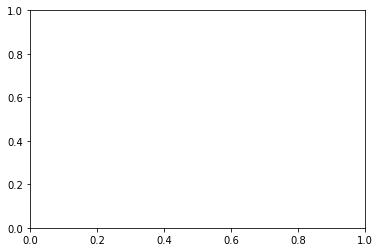

In [43]:
for epochs in number_of_epochs:
  print('Number of epochs:', epochs)
  model = create_elmo_using_model()
  print(model.summary())
  model.compile(loss='binary_crossentropy', optimizer=this_optimizer, metrics=['accuracy'])
  history = model.fit(
      X_train_elmo, 
      y_train_elmo,
      epochs=epochs,
      batch_size=batch_size
  )
  print('Done training')
  image_save_file_name = 'drive/My Drive/CA5_Sabri_810198312/Results/Q3_repeat_q1_part_1_elmo_model_{}_epochs'.format(epochs)
  plot_accuracy_and_loss(image_save_file_name, history)
  evaluate_model_elmo(model)

**1 Epoch**


```
Accuracy: 0.9883408071748879
Classification report:               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       1.00      0.91      0.95       150

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

F1 (Micro): 0.9883408071748879
F1 (Macro): 0.9740065741220606
F1 (Weighted): 0.9881157527912083
Recall (Micro): 0.9883408071748879
Recall (Macro): 0.9566666666666667
Recall (Weighted): 0.9883408071748879
Precision (Micro): 0.9883408071748879
Precision (Macro): 0.9933537832310839
Precision (Weighted): 0.9884957862206205
AUC: 0.9566666666666667
```

**10 Epochs**

```
Accuracy: 0.9901345291479821
Classification report:               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.98      0.95      0.96       150

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

F1 (Micro): 0.9901345291479821
F1 (Macro): 0.978513554942408
F1 (Weighted): 0.9900636695491676
Recall (Micro): 0.9901345291479821
Recall (Macro): 0.9717789291882556
Recall (Weighted): 0.9901345291479821
Precision (Micro): 0.9901345291479821
Precision (Macro): 0.9855314610735869
Precision (Weighted): 0.990078734383444
AUC: 0.9717789291882556
```

**20 Epochs**

```
Accuracy: 0.9901345291479821
Classification report:               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.99      0.94      0.96       150

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

F1 (Micro): 0.9901345291479821
F1 (Macro): 0.9783892265052216
F1 (Weighted): 0.9900345083225569
Recall (Micro): 0.9901345291479821
Recall (Macro): 0.9689637305699481
Recall (Weighted): 0.9901345291479821
Precision (Micro): 0.9901345291479821
Precision (Macro): 0.9883773633773634
Precision (Weighted): 0.9901048544546303
AUC: 0.9689637305699481
```

**50 Epochs**

```
Accuracy: 0.989237668161435
Classification report:               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.98      0.94      0.96       150

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

F1 (Micro): 0.989237668161435
F1 (Macro): 0.9764926631809748
F1 (Weighted): 0.9891445256159017
Recall (Micro): 0.989237668161435
Recall (Macro): 0.9684455958549223
Recall (Weighted): 0.989237668161435
Precision (Micro): 0.989237668161435
Precision (Macro): 0.984948935805012
Precision (Weighted): 0.9891754374621882
AUC: 0.9684455958549223
```